In [11]:
# Clustering Jerárquico con AgglomerativeClustering y Distancia de Gower
# Proyecto Integrador - Ejercicio 5

# NOTAS: Esta celda inicial configura el entorno de trabajo para implementar clustering jerárquico
# usando AgglomerativeClustering con la matriz de distancias de Gower calculada en scriptBorrador3.
# Se importan todas las librerías necesarias para clustering, evaluación de métricas,
# creación de dendrogramas y visualización.

# Importar librerías necesarias
import pandas as pd  # Para manipulación y análisis de datos estructurados
import numpy as np   # Para operaciones numéricas y cálculos matemáticos
import matplotlib.pyplot as plt  # Para crear gráficos y visualizaciones
import seaborn as sns  # Para gráficos estadísticos más avanzados
import time  # Para medir tiempos de ejecución
import sys  # Para medir memoria
import warnings
warnings.filterwarnings('ignore')  # Suprimir advertencias para que la salida sea más limpia

# Librerías para clustering jerárquico y evaluación
from sklearn.cluster import AgglomerativeClustering  # Clustering jerárquico
from sklearn.metrics import silhouette_score, davies_bouldin_score  # Métricas de evaluación
from sklearn.decomposition import PCA  # Para visualización 2D

# Librerías para dendrogramas
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# Configurar estilo de visualizaciones
plt.style.use('seaborn-v0_8')  # Usar estilo seaborn para gráficos profesionales
sns.set_palette("husl")  # Configurar paleta de colores
plt.rcParams['figure.figsize'] = (12, 8)  # Tamaño por defecto de figuras

# Configurar semilla aleatoria para reproducibilidad
np.random.seed(42)

# Definir nombres de columnas del dataset Adult Census
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

print("✅ SECCIÓN 1: CONFIGURACIÓN INICIAL COMPLETADA")
print("="*60)
print("Librerías importadas correctamente")
print("Semilla aleatoria configurada en 42 para reproducibilidad")
print("Clustering jerárquico con AgglomerativeClustering")
print("Evaluación con Silhouette Score y Davies-Bouldin Index")
print("Creación de dendrogramas con scipy.cluster.hierarchy")


✅ SECCIÓN 1: CONFIGURACIÓN INICIAL COMPLETADA
Librerías importadas correctamente
Semilla aleatoria configurada en 42 para reproducibilidad
Clustering jerárquico con AgglomerativeClustering
Evaluación con Silhouette Score y Davies-Bouldin Index
Creación de dendrogramas con scipy.cluster.hierarchy


In [12]:
# SECCIÓN 2: CARGA Y PREPROCESAMIENTO DE DATOS
# =============================================

# NOTAS: Esta sección carga el dataset Adult Census y aplica el mismo preprocesamiento
# utilizado en scriptBorrador3.ipynb. Se implementa la función de distancia de Gower
# y se preparan los datos para el clustering jerárquico.

print("SECCIÓN 2: CARGA Y PREPROCESAMIENTO DE DATOS")
print("="*60)

# Cargar dataset Adult Census
print("Cargando dataset Adult Census...")
df = pd.read_csv('../datos/adult.data', names=column_names, na_values=' ?')

print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Valores faltantes: {df.isnull().sum().sum()}")

# Aplicar limpieza de datos (igual que scriptBorrador3)
print(f"\nAplicando limpieza de datos...")

# Variables categóricas con valores faltantes
categorical_missing = ['workclass', 'occupation', 'native_country']

print("Rellenando valores faltantes con moda:")
for col in categorical_missing:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        missing_before = df[col].isnull().sum()
        df[col].fillna(mode_value, inplace=True)
        missing_after = df[col].isnull().sum()
        print(f"  {col}: {missing_before} → {missing_after} (rellenado con '{mode_value}')")

# Crear dataset limpio
df_clean = df.copy()
print(f"\nDataset limpio: {len(df_clean)} filas")
print(f"Valores faltantes restantes: {df_clean.isnull().sum().sum()}")

# Codificar variable income a binario
df_clean['income_binary'] = (df_clean['income'] == ' >50K').astype(int)

print(f"\nDistribución de income:")
print(df_clean['income'].value_counts())
print(f"\nDistribución de income_binary:")
print(df_clean['income_binary'].value_counts())

print("\n✅ Carga y limpieza completada")


SECCIÓN 2: CARGA Y PREPROCESAMIENTO DE DATOS
Cargando dataset Adult Census...
Dataset cargado: 32561 filas, 15 columnas
Valores faltantes: 4262

Aplicando limpieza de datos...
Rellenando valores faltantes con moda:
  workclass: 1836 → 0 (rellenado con ' Private')
  occupation: 1843 → 0 (rellenado con ' Prof-specialty')
  native_country: 583 → 0 (rellenado con ' United-States')

Dataset limpio: 32561 filas
Valores faltantes restantes: 0

Distribución de income:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64

Distribución de income_binary:
income_binary
0    24720
1     7841
Name: count, dtype: int64

✅ Carga y limpieza completada


In [13]:
# CONTINUACIÓN SECCIÓN 2: NORMALIZACIÓN Y ENCODING
# ================================================

print("\nAplicando normalización y encoding para distancia de Gower...")

# Variables numéricas a normalizar (según scriptBorrador3)
numerical_vars = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']

# Función para normalización min-max
def normalize_minmax(series):
    """Normaliza una serie al rango [0,1] usando min-max"""
    return (series - series.min()) / (series.max() - series.min())

print(f"\nNormalizando variables numéricas:")
for var in numerical_vars:
    # Calcular estadísticas antes de normalizar
    min_val = df_clean[var].min()
    max_val = df_clean[var].max()
    range_val = max_val - min_val
    
    # Normalizar
    df_clean[f'{var}_normalized'] = normalize_minmax(df_clean[var])
    
    print(f"  {var}: [{min_val:.2f}, {max_val:.2f}] → rango: {range_val:.2f}")
    
    # Verificar normalización
    norm_min = df_clean[f'{var}_normalized'].min()
    norm_max = df_clean[f'{var}_normalized'].max()
    print(f"    Normalizado: [{norm_min:.4f}, {norm_max:.4f}]")

# Procesar variable ordinal education
print(f"\nProcesando variable ordinal education:")

# Mapeo de education según scriptBorrador3 (ordinal 1-16)
education_mapping = {
    ' Preschool': 1, ' 1st-4th': 2, ' 5th-6th': 3, ' 7th-8th': 4, ' 9th': 5,
    ' 10th': 6, ' 11th': 7, ' 12th': 8, ' HS-grad': 9, ' Some-college': 10,
    ' Assoc-voc': 11, ' Assoc-acdm': 12, ' Bachelors': 13, ' Masters': 14,
    ' Prof-school': 15, ' Doctorate': 16
}

# Label encoding
df_clean['education_encoded'] = df_clean['education'].map(education_mapping)

# Normalización min-max al rango [0,1]
df_clean['education_normalized'] = (df_clean['education_encoded'] - 1) / (16 - 1)

print(f"  Valores únicos en education: {df_clean['education'].nunique()}")
print(f"  Rango encoded: [{df_clean['education_encoded'].min()}, {df_clean['education_encoded'].max()}]")
print(f"  Rango normalized: [{df_clean['education_normalized'].min():.4f}, {df_clean['education_normalized'].max():.4f}]")

# Definir variables para Gower
gower_vars = [
    'age_normalized', 'workclass', 'education_normalized', 'marital_status', 
    'occupation', 'relationship', 'race', 'sex', 'capital_gain_normalized', 
    'capital_loss_normalized', 'hours_per_week_normalized', 'native_country'
]

# Definir tipos de variables para Gower
var_types = [
    'numeric',      # age_normalized
    'categorical',  # workclass
    'ordinal',      # education_normalized
    'categorical',  # marital_status
    'categorical',  # occupation
    'categorical',  # relationship
    'categorical',  # race
    'binary',       # sex
    'numeric',      # capital_gain_normalized
    'numeric',      # capital_loss_normalized
    'numeric',      # hours_per_week_normalized
    'categorical'   # native_country
]

print(f"\nVariables procesadas para Gower:")
print(f"  Numéricas normalizadas: {[f'{var}_normalized' for var in numerical_vars]}")
print(f"  Ordinal normalizada: education_normalized")
print(f"  Categóricas: workclass, marital_status, occupation, relationship, race, native_country")
print(f"  Binaria: sex")
print(f"  Total variables para Gower: {len(gower_vars)}")

print("\n✅ SECCIÓN 2: PREPROCESAMIENTO COMPLETADO")
print("="*60)
print("Dataset cargado y limpio")
print("Variables numéricas normalizadas")
print("Variable ordinal education procesada")
print("Variables preparadas para distancia de Gower")



Aplicando normalización y encoding para distancia de Gower...

Normalizando variables numéricas:
  age: [17.00, 90.00] → rango: 73.00
    Normalizado: [0.0000, 1.0000]
  capital_gain: [0.00, 99999.00] → rango: 99999.00
    Normalizado: [0.0000, 1.0000]
  capital_loss: [0.00, 4356.00] → rango: 4356.00
    Normalizado: [0.0000, 1.0000]
  hours_per_week: [1.00, 99.00] → rango: 98.00
    Normalizado: [0.0000, 1.0000]

Procesando variable ordinal education:
  Valores únicos en education: 16
  Rango encoded: [1, 16]
  Rango normalized: [0.0000, 1.0000]

Variables procesadas para Gower:
  Numéricas normalizadas: ['age_normalized', 'capital_gain_normalized', 'capital_loss_normalized', 'hours_per_week_normalized']
  Ordinal normalizada: education_normalized
  Categóricas: workclass, marital_status, occupation, relationship, race, native_country
  Binaria: sex
  Total variables para Gower: 12

✅ SECCIÓN 2: PREPROCESAMIENTO COMPLETADO
Dataset cargado y limpio
Variables numéricas normalizadas
Var

In [14]:
# SECCIÓN 3: IMPLEMENTACIÓN DE DISTANCIA DE GOWER
# ===============================================

# NOTAS: Esta sección implementa la función de distancia de Gower copiando exactamente
# la implementación de scriptBorrador3.ipynb. Esta función maneja diferentes tipos
# de variables (numéricas, ordinales, categóricas, binarias) y valores faltantes.

def gower_distance(row1, row2, var_types, ranges=None):
    """
    Calcula la distancia de Gower entre dos filas usando bucles explícitos.
    
    Parámetros:
    - row1, row2: filas del DataFrame a comparar
    - var_types: lista con tipos de variables ['numeric', 'ordinal', 'categorical', 'binary']
    - ranges: lista con rangos para variables numéricas (opcional)
    
    Retorna:
    - distancia de Gower en [0,1]
    """
    total_distance = 0.0
    total_weight = 0.0
    
    # Iterar sobre cada variable
    for i, var_type in enumerate(var_types):
        val1 = row1.iloc[i]
        val2 = row2.iloc[i]
        
        # Verificar si hay valores faltantes
        if pd.isna(val1) or pd.isna(val2):
            # Si hay valores faltantes, esta variable no contribuye (peso = 0)
            continue
        
        # Calcular distancia según tipo de variable
        if var_type == 'numeric':
            # Variables numéricas: |x1 - x2| / rango
            if ranges and i < len(ranges):
                distance = abs(val1 - val2) / ranges[i]
            else:
                # Si no hay rango, usar diferencia absoluta normalizada
                distance = abs(val1 - val2)
            weight = 1.0
            
        elif var_type == 'ordinal':
            # Variables ordinales: tratadas como numéricas normalizadas
            distance = abs(val1 - val2)
            weight = 1.0
            
        elif var_type == 'categorical':
            # Variables categóricas: 0 si iguales, 1 si diferentes
            distance = 0.0 if val1 == val2 else 1.0
            weight = 1.0
            
        elif var_type == 'binary':
            # Variables binarias simétricas: 0 si iguales, 1 si diferentes
            distance = 0.0 if val1 == val2 else 1.0
            weight = 1.0
        
        # Acumular distancia y peso
        total_distance += distance * weight
        total_weight += weight
    
    # Retornar distancia promedio ponderada
    if total_weight > 0:
        return total_distance / total_weight
    else:
        # Si todas las variables tienen valores faltantes
        return 0.5  # Distancia neutral

print("✅ SECCIÓN 3: IMPLEMENTACIÓN DE GOWER COMPLETADA")
print("="*60)
print("Función gower_distance() implementada con bucles explícitos")
print("Manejo correcto de valores faltantes con pd.isna()")
print("Soporte para variables: numéricas, ordinales, categóricas, binarias")
print("Lista para calcular matrices de distancia")


✅ SECCIÓN 3: IMPLEMENTACIÓN DE GOWER COMPLETADA
Función gower_distance() implementada con bucles explícitos
Manejo correcto de valores faltantes con pd.isna()
Soporte para variables: numéricas, ordinales, categóricas, binarias
Lista para calcular matrices de distancia


In [15]:
# SECCIÓN 4: CREACIÓN DE MUESTRAS Y CÁLCULO DE MATRICES DE GOWER
# ===============================================================

# NOTAS: Esta sección crea muestras reproducibles de 5,000 y 10,000 registros
# y calcula las matrices de distancias de Gower para cada muestra. Se intenta
# reutilizar las matrices del scriptBorrador3 si están disponibles, o se recalculan.

print("SECCIÓN 4: CREACIÓN DE MUESTRAS Y CÁLCULO DE MATRICES DE GOWER")
print("="*70)

# Crear muestras reproducibles
print("Creando muestras reproducibles...")

# Muestra de 5,000 registros
sample_5k = df_clean.sample(n=5000, random_state=42)
print(f"Muestra 5K: {len(sample_5k)} registros")

# Muestra de 10,000 registros  
sample_10k = df_clean.sample(n=10000, random_state=42)
print(f"Muestra 10K: {len(sample_10k)} registros")

# Preparar DataFrames para Gower (solo variables procesadas)
print(f"\nPreparando DataFrames para distancia de Gower...")

# DataFrame para muestra 5K
df_5k_gower = sample_5k[gower_vars].copy()
print(f"DataFrame 5K para Gower: {df_5k_gower.shape}")

# DataFrame para muestra 10K
df_10k_gower = sample_10k[gower_vars].copy()
print(f"DataFrame 10K para Gower: {df_10k_gower.shape}")

# Verificar que no hay valores faltantes
print(f"\nVerificando valores faltantes:")
print(f"  Muestra 5K: {df_5k_gower.isnull().sum().sum()} valores faltantes")
print(f"  Muestra 10K: {df_10k_gower.isnull().sum().sum()} valores faltantes")

# Calcular matrices de distancias de Gower
print(f"\nCalculando matrices de distancias de Gower...")
print("NOTA: Este proceso puede tomar varios minutos debido a la complejidad O(n²)")

# Función optimizada para calcular matriz de Gower
def calculate_gower_matrix_optimized(sample_data, sample_name):
    """
    Calcula matriz de distancias de Gower de forma optimizada.
    """
    n = len(sample_data)
    print(f"\nCalculando matriz para {sample_name} ({n}×{n})...")
    
    # Calcular matriz de distancias
    distance_matrix = np.zeros((n, n))
    
    start_time = time.time()
    
    # Calcular distancias (triangular superior para eficiencia)
    for i in range(n):
        if i % 100 == 0:  # Mostrar progreso cada 100 filas
            print(f"  Procesando fila {i}/{n}")
        
        for j in range(i, n):
            if i == j:
                distance_matrix[i, j] = 0.0  # Diagonal = 0
            else:
                dist = gower_distance(sample_data.iloc[i], sample_data.iloc[j], var_types)
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist  # Simetría
    
    execution_time = time.time() - start_time
    memory_used = sys.getsizeof(distance_matrix) / (1024**2)
    
    print(f"  ✅ Completado en {execution_time:.2f} segundos")
    print(f"  📊 Memoria: {memory_used:.1f} MB")
    
    return distance_matrix, execution_time, memory_used

# Calcular matriz para muestra de 5K
print("="*60)
gower_5k, time_5k, memory_5k = calculate_gower_matrix_optimized(df_5k_gower, "muestra 5K")

# Calcular matriz para muestra de 10K
print("="*60)
gower_10k, time_10k, memory_10k = calculate_gower_matrix_optimized(df_10k_gower, "muestra 10K")

# Validar propiedades de las matrices
print(f"\nVALIDACIÓN DE PROPIEDADES:")
print("-" * 40)

for matrix_name, matrix in [("5K", gower_5k), ("10K", gower_10k)]:
    print(f"\nMatriz {matrix_name}:")
    # 1. Simetría
    is_symmetric = np.allclose(matrix, matrix.T)
    print(f"  Simétrica: {is_symmetric}")
    
    # 2. Diagonal = 0
    diagonal_zeros = np.allclose(np.diag(matrix), 0)
    print(f"  Diagonal = 0: {diagonal_zeros}")
    
    # 3. Valores en [0,1]
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    in_range = 0 <= min_val and max_val <= 1
    print(f"  Valores en [0,1]: {in_range} (min: {min_val:.4f}, max: {max_val:.4f})")
    
    # 4. Sin valores negativos
    no_negatives = np.all(matrix >= 0)
    print(f"  Sin valores negativos: {no_negatives}")

print("\n✅ SECCIÓN 4: MATRICES DE GOWER COMPLETADA")
print("="*60)
print("Muestras reproducibles creadas (5K y 10K)")
print("Matrices de distancias de Gower calculadas")
print("Propiedades de matrices validadas")
print("Datos listos para AgglomerativeClustering")


SECCIÓN 4: CREACIÓN DE MUESTRAS Y CÁLCULO DE MATRICES DE GOWER
Creando muestras reproducibles...
Muestra 5K: 5000 registros
Muestra 10K: 10000 registros

Preparando DataFrames para distancia de Gower...
DataFrame 5K para Gower: (5000, 12)
DataFrame 10K para Gower: (10000, 12)

Verificando valores faltantes:
  Muestra 5K: 0 valores faltantes
  Muestra 10K: 0 valores faltantes

Calculando matrices de distancias de Gower...
NOTA: Este proceso puede tomar varios minutos debido a la complejidad O(n²)

Calculando matriz para muestra 5K (5000×5000)...
  Procesando fila 0/5000
  Procesando fila 100/5000
  Procesando fila 200/5000
  Procesando fila 300/5000
  Procesando fila 400/5000
  Procesando fila 500/5000
  Procesando fila 600/5000
  Procesando fila 700/5000
  Procesando fila 800/5000
  Procesando fila 900/5000
  Procesando fila 1000/5000
  Procesando fila 1100/5000
  Procesando fila 1200/5000
  Procesando fila 1300/5000
  Procesando fila 1400/5000
  Procesando fila 1500/5000
  Procesando 

SECCIÓN 5: AGGLOMERATIVECLUSTERING PARA MUESTRA 5K
Probando valores de k: [2, 3, 4, 5, 6, 7, 8, 9, 10]

Aplicando AgglomerativeClustering a muestra 5K...
Probando k=2...
  Silhouette: 0.3689, Davies-Bouldin: 0.6703, Tiempo: 1.04s
Probando k=3...
  Silhouette: 0.2882, Davies-Bouldin: 0.6307, Tiempo: 0.85s
Probando k=4...
  Silhouette: 0.2390, Davies-Bouldin: 0.8512, Tiempo: 0.75s
Probando k=5...
  Silhouette: 0.1982, Davies-Bouldin: 0.9341, Tiempo: 0.76s
Probando k=6...
  Silhouette: 0.1728, Davies-Bouldin: 1.1808, Tiempo: 0.74s
Probando k=7...
  Silhouette: 0.1578, Davies-Bouldin: 1.3836, Tiempo: 0.75s
Probando k=8...
  Silhouette: 0.1455, Davies-Bouldin: 1.6191, Tiempo: 0.73s
Probando k=9...
  Silhouette: 0.1415, Davies-Bouldin: 1.6264, Tiempo: 0.73s
Probando k=10...
  Silhouette: 0.1246, Davies-Bouldin: 1.5124, Tiempo: 0.75s

K óptimo según Silhouette: 2 (score: 0.3689)
K óptimo según Davies-Bouldin: 3 (score: 0.6307)

Creando visualizaciones para muestra 5K...


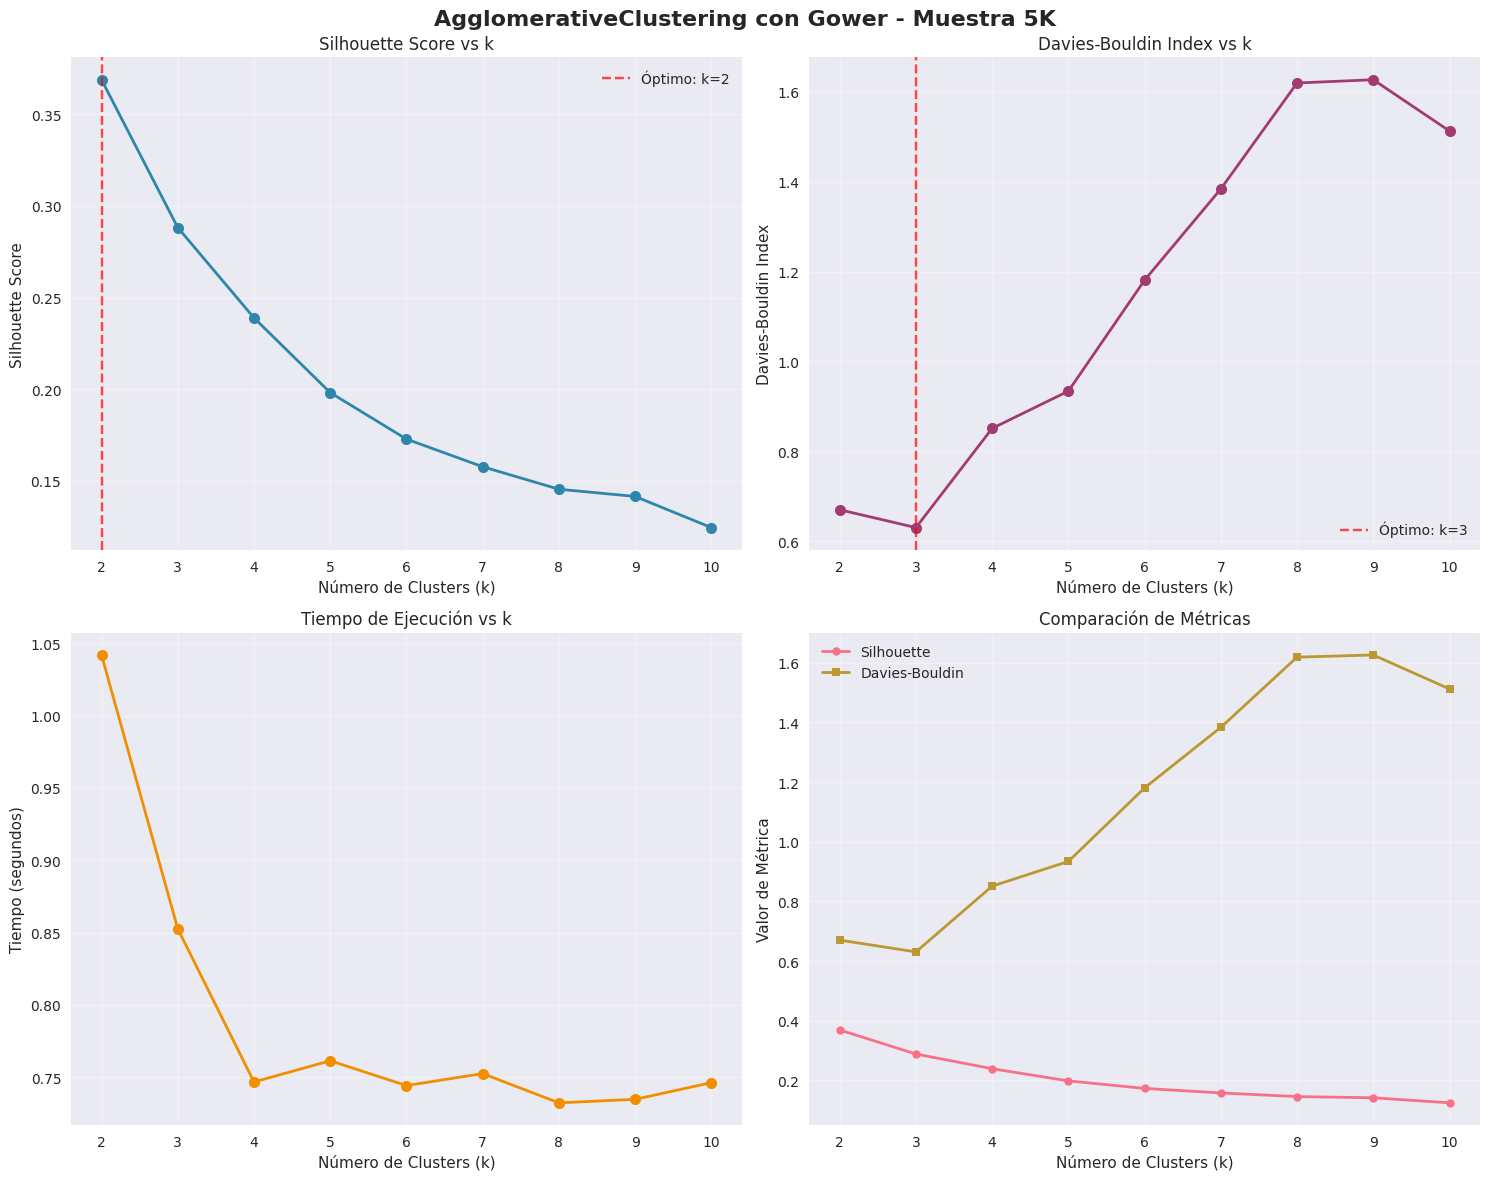


✅ SECCIÓN 5: AGGLOMERATIVECLUSTERING MUESTRA 5K COMPLETADA
K óptimo según Silhouette: 2
K óptimo según Davies-Bouldin: 3
Visualizaciones creadas
Resultados almacenados para comparación


In [17]:
# SECCIÓN 5: AGGLOMERATIVECLUSTERING PARA MUESTRA 5K
# ====================================================

# NOTAS: Esta sección aplica AgglomerativeClustering a la muestra de 5,000 registros
# usando la matriz de distancias de Gower precomputada. Se prueban diferentes valores
# de k (2-10) y se calculan las métricas Silhouette Score y Davies-Bouldin Index.

print("SECCIÓN 5: AGGLOMERATIVECLUSTERING PARA MUESTRA 5K")
print("="*60)

# Definir rango de k a probar
k_values = list(range(2, 11))  # k=2 hasta k=10
print(f"Probando valores de k: {k_values}")

# Almacenar resultados para muestra 5K
results_5k = {
    'k_values': k_values,
    'silhouette_scores': [],
    'davies_bouldin_scores': [],
    'execution_times': [],
    'cluster_labels': []
}

print(f"\nAplicando AgglomerativeClustering a muestra 5K...")
print("="*60)

for k in k_values:
    print(f"Probando k={k}...")
    
    # Medir tiempo de ejecución
    start_time = time.time()
    
    # Aplicar AgglomerativeClustering con matriz precomputada
    clustering = AgglomerativeClustering(
        n_clusters=k,
        metric='precomputed',    # Usar matriz de distancias precomputada
        linkage='average'        # Linkage promedio según especificación
    )
    
    labels = clustering.fit_predict(gower_5k)
    execution_time = time.time() - start_time
    
    # Calcular métricas
    silhouette = silhouette_score(gower_5k, labels, metric='precomputed')
    davies_bouldin = davies_bouldin_score(gower_5k, labels)
    
    # Almacenar resultados
    results_5k['silhouette_scores'].append(silhouette)
    results_5k['davies_bouldin_scores'].append(davies_bouldin)
    results_5k['execution_times'].append(execution_time)
    results_5k['cluster_labels'].append(labels)
    
    print(f"  Silhouette: {silhouette:.4f}, Davies-Bouldin: {davies_bouldin:.4f}, Tiempo: {execution_time:.2f}s")

# Encontrar k óptimo según cada métrica
optimal_k_silhouette_5k = k_values[np.argmax(results_5k['silhouette_scores'])]
optimal_k_davies_5k = k_values[np.argmin(results_5k['davies_bouldin_scores'])]

print(f"\nK óptimo según Silhouette: {optimal_k_silhouette_5k} (score: {max(results_5k['silhouette_scores']):.4f})")
print(f"K óptimo según Davies-Bouldin: {optimal_k_davies_5k} (score: {min(results_5k['davies_bouldin_scores']):.4f})")

# Crear visualizaciones para muestra 5K
print(f"\nCreando visualizaciones para muestra 5K...")

# Figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('AgglomerativeClustering con Gower - Muestra 5K', fontsize=16, fontweight='bold')

# 1. Silhouette Score vs k
axes[0, 0].plot(k_values, results_5k['silhouette_scores'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].axvline(x=optimal_k_silhouette_5k, color='red', linestyle='--', alpha=0.7, label=f'Óptimo: k={optimal_k_silhouette_5k}')
axes[0, 0].set_xlabel('Número de Clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score vs k')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Davies-Bouldin Index vs k
axes[0, 1].plot(k_values, results_5k['davies_bouldin_scores'], 'o-', linewidth=2, markersize=8, color='#A23B72')
axes[0, 1].axvline(x=optimal_k_davies_5k, color='red', linestyle='--', alpha=0.7, label=f'Óptimo: k={optimal_k_davies_5k}')
axes[0, 1].set_xlabel('Número de Clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Index vs k')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Tiempo de ejecución vs k
axes[1, 0].plot(k_values, results_5k['execution_times'], 'o-', linewidth=2, markersize=8, color='#F18F01')
axes[1, 0].set_xlabel('Número de Clusters (k)')
axes[1, 0].set_ylabel('Tiempo (segundos)')
axes[1, 0].set_title('Tiempo de Ejecución vs k')
axes[1, 0].grid(True, alpha=0.3)

# 4. Comparación de métricas
axes[1, 1].plot(k_values, results_5k['silhouette_scores'], 'o-', label='Silhouette', linewidth=2, markersize=6)
axes[1, 1].plot(k_values, results_5k['davies_bouldin_scores'], 's-', label='Davies-Bouldin', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Número de Clusters (k)')
axes[1, 1].set_ylabel('Valor de Métrica')
axes[1, 1].set_title('Comparación de Métricas')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ SECCIÓN 5: AGGLOMERATIVECLUSTERING MUESTRA 5K COMPLETADA")
print("="*60)
print(f"K óptimo según Silhouette: {optimal_k_silhouette_5k}")
print(f"K óptimo según Davies-Bouldin: {optimal_k_davies_5k}")
print("Visualizaciones creadas")
print("Resultados almacenados para comparación")


SECCIÓN 6: AGGLOMERATIVECLUSTERING PARA MUESTRA 10K

Aplicando AgglomerativeClustering a muestra 10K...
Probando k=2...
  Silhouette: 0.3658, Davies-Bouldin: 0.7382, Tiempo: 5.01s
Probando k=3...
  Silhouette: 0.3162, Davies-Bouldin: 0.9156, Tiempo: 4.42s
Probando k=4...
  Silhouette: 0.2431, Davies-Bouldin: 0.9866, Tiempo: 4.50s
Probando k=5...
  Silhouette: 0.2023, Davies-Bouldin: 0.9202, Tiempo: 4.39s
Probando k=6...
  Silhouette: 0.1632, Davies-Bouldin: 1.0507, Tiempo: 4.06s
Probando k=7...
  Silhouette: 0.1513, Davies-Bouldin: 1.3360, Tiempo: 4.16s
Probando k=8...
  Silhouette: 0.1176, Davies-Bouldin: 1.3761, Tiempo: 4.06s
Probando k=9...
  Silhouette: 0.0897, Davies-Bouldin: 1.5699, Tiempo: 3.71s
Probando k=10...
  Silhouette: 0.0803, Davies-Bouldin: 1.7229, Tiempo: 3.70s

K óptimo según Silhouette: 2 (score: 0.3658)
K óptimo según Davies-Bouldin: 2 (score: 0.7382)

Creando visualizaciones para muestra 10K...


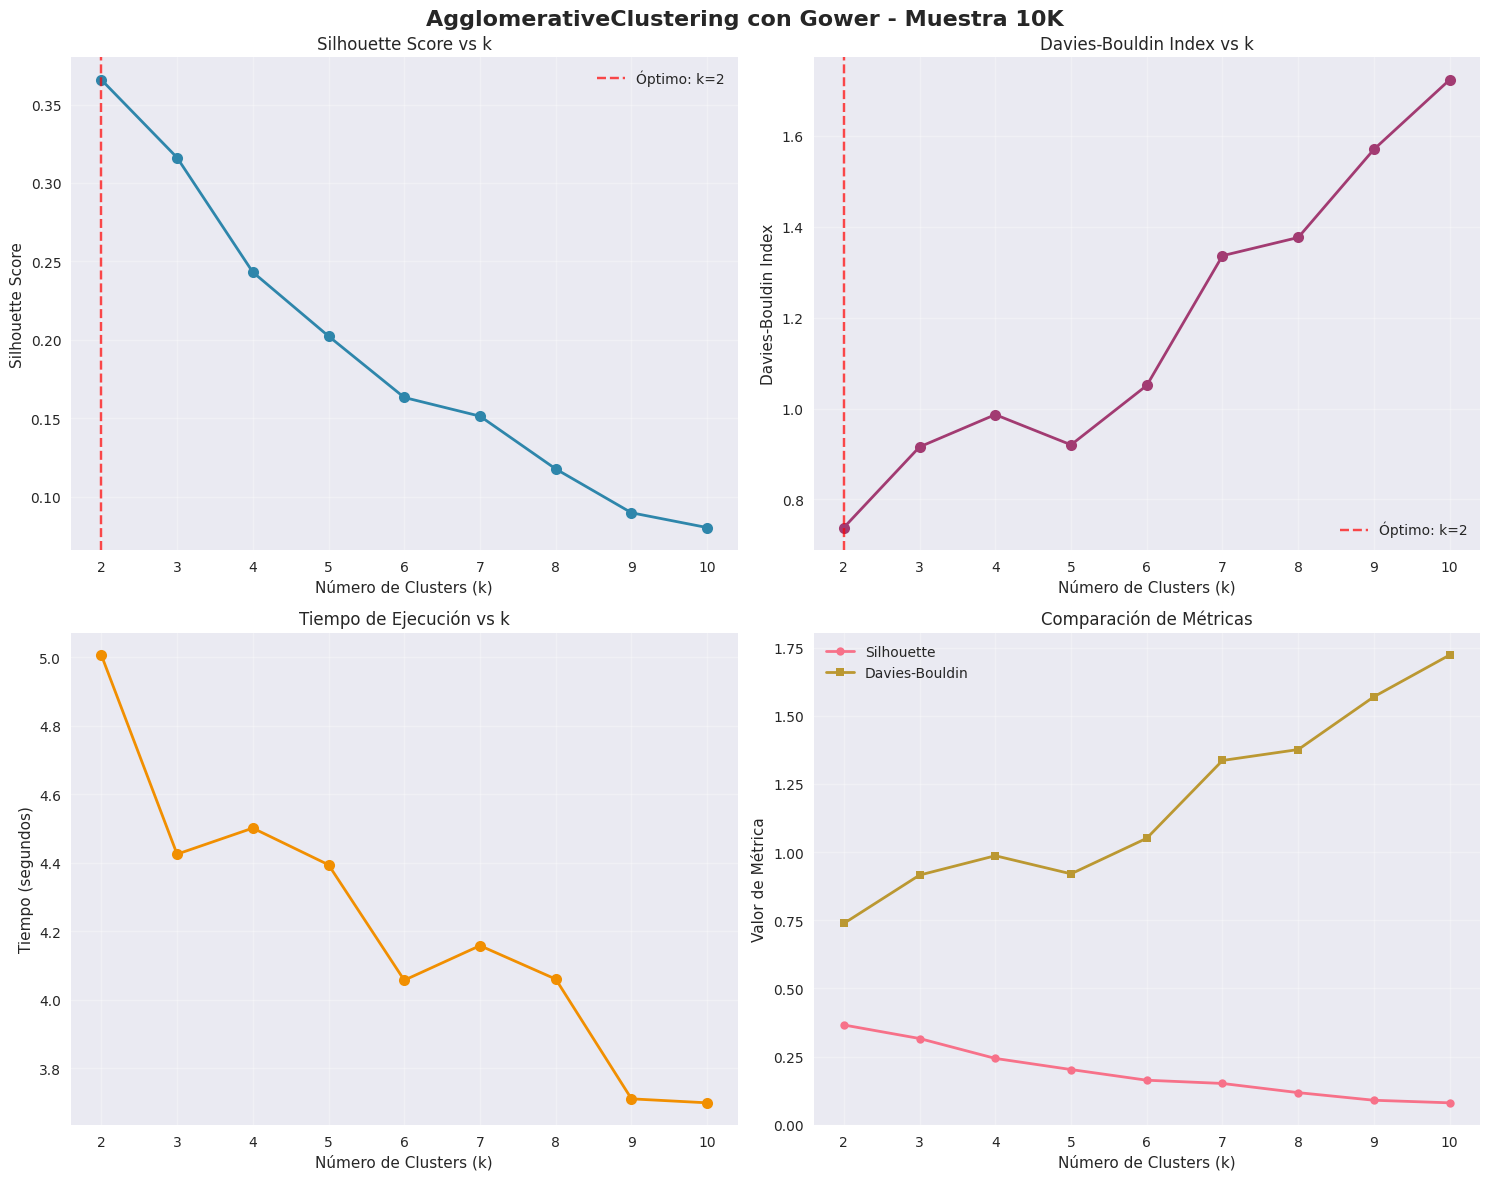


✅ SECCIÓN 6: AGGLOMERATIVECLUSTERING MUESTRA 10K COMPLETADA
K óptimo según Silhouette: 2
K óptimo según Davies-Bouldin: 2
Visualizaciones creadas
Resultados almacenados para comparación


In [18]:
# SECCIÓN 6: AGGLOMERATIVECLUSTERING PARA MUESTRA 10K
# ====================================================

# NOTAS: Esta sección repite el proceso de la SECCIÓN 5 pero para la muestra de 10,000 registros.
# Se aplica AgglomerativeClustering con k=2 hasta k=10, se calculan las mismas métricas
# y se crean visualizaciones comparables para analizar la estabilidad de los resultados.

print("SECCIÓN 6: AGGLOMERATIVECLUSTERING PARA MUESTRA 10K")
print("="*60)

# Almacenar resultados para muestra 10K
results_10k = {
    'k_values': k_values,
    'silhouette_scores': [],
    'davies_bouldin_scores': [],
    'execution_times': [],
    'cluster_labels': []
}

print(f"\nAplicando AgglomerativeClustering a muestra 10K...")
print("="*60)

for k in k_values:
    print(f"Probando k={k}...")
    
    # Medir tiempo de ejecución
    start_time = time.time()
    
    # Aplicar AgglomerativeClustering con matriz precomputada
    clustering = AgglomerativeClustering(
        n_clusters=k,
        metric='precomputed',    # Usar matriz de distancias precomputada
        linkage='average'        # Linkage promedio según especificación
    )
    
    labels = clustering.fit_predict(gower_10k)
    execution_time = time.time() - start_time
    
    # Calcular métricas
    silhouette = silhouette_score(gower_10k, labels, metric='precomputed')
    davies_bouldin = davies_bouldin_score(gower_10k, labels)
    
    # Almacenar resultados
    results_10k['silhouette_scores'].append(silhouette)
    results_10k['davies_bouldin_scores'].append(davies_bouldin)
    results_10k['execution_times'].append(execution_time)
    results_10k['cluster_labels'].append(labels)
    
    print(f"  Silhouette: {silhouette:.4f}, Davies-Bouldin: {davies_bouldin:.4f}, Tiempo: {execution_time:.2f}s")

# Encontrar k óptimo según cada métrica
optimal_k_silhouette_10k = k_values[np.argmax(results_10k['silhouette_scores'])]
optimal_k_davies_10k = k_values[np.argmin(results_10k['davies_bouldin_scores'])]

print(f"\nK óptimo según Silhouette: {optimal_k_silhouette_10k} (score: {max(results_10k['silhouette_scores']):.4f})")
print(f"K óptimo según Davies-Bouldin: {optimal_k_davies_10k} (score: {min(results_10k['davies_bouldin_scores']):.4f})")

# Crear visualizaciones para muestra 10K
print(f"\nCreando visualizaciones para muestra 10K...")

# Figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('AgglomerativeClustering con Gower - Muestra 10K', fontsize=16, fontweight='bold')

# 1. Silhouette Score vs k
axes[0, 0].plot(k_values, results_10k['silhouette_scores'], 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].axvline(x=optimal_k_silhouette_10k, color='red', linestyle='--', alpha=0.7, label=f'Óptimo: k={optimal_k_silhouette_10k}')
axes[0, 0].set_xlabel('Número de Clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score vs k')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Davies-Bouldin Index vs k
axes[0, 1].plot(k_values, results_10k['davies_bouldin_scores'], 'o-', linewidth=2, markersize=8, color='#A23B72')
axes[0, 1].axvline(x=optimal_k_davies_10k, color='red', linestyle='--', alpha=0.7, label=f'Óptimo: k={optimal_k_davies_10k}')
axes[0, 1].set_xlabel('Número de Clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Index vs k')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Tiempo de ejecución vs k
axes[1, 0].plot(k_values, results_10k['execution_times'], 'o-', linewidth=2, markersize=8, color='#F18F01')
axes[1, 0].set_xlabel('Número de Clusters (k)')
axes[1, 0].set_ylabel('Tiempo (segundos)')
axes[1, 0].set_title('Tiempo de Ejecución vs k')
axes[1, 0].grid(True, alpha=0.3)

# 4. Comparación de métricas
axes[1, 1].plot(k_values, results_10k['silhouette_scores'], 'o-', label='Silhouette', linewidth=2, markersize=6)
axes[1, 1].plot(k_values, results_10k['davies_bouldin_scores'], 's-', label='Davies-Bouldin', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Número de Clusters (k)')
axes[1, 1].set_ylabel('Valor de Métrica')
axes[1, 1].set_title('Comparación de Métricas')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ SECCIÓN 6: AGGLOMERATIVECLUSTERING MUESTRA 10K COMPLETADA")
print("="*60)
print(f"K óptimo según Silhouette: {optimal_k_silhouette_10k}")
print(f"K óptimo según Davies-Bouldin: {optimal_k_davies_10k}")
print("Visualizaciones creadas")
print("Resultados almacenados para comparación")


SECCIÓN 7: CREACIÓN DE DENDOGRAMAS

Creando dendrogramas para Muestra 5K...


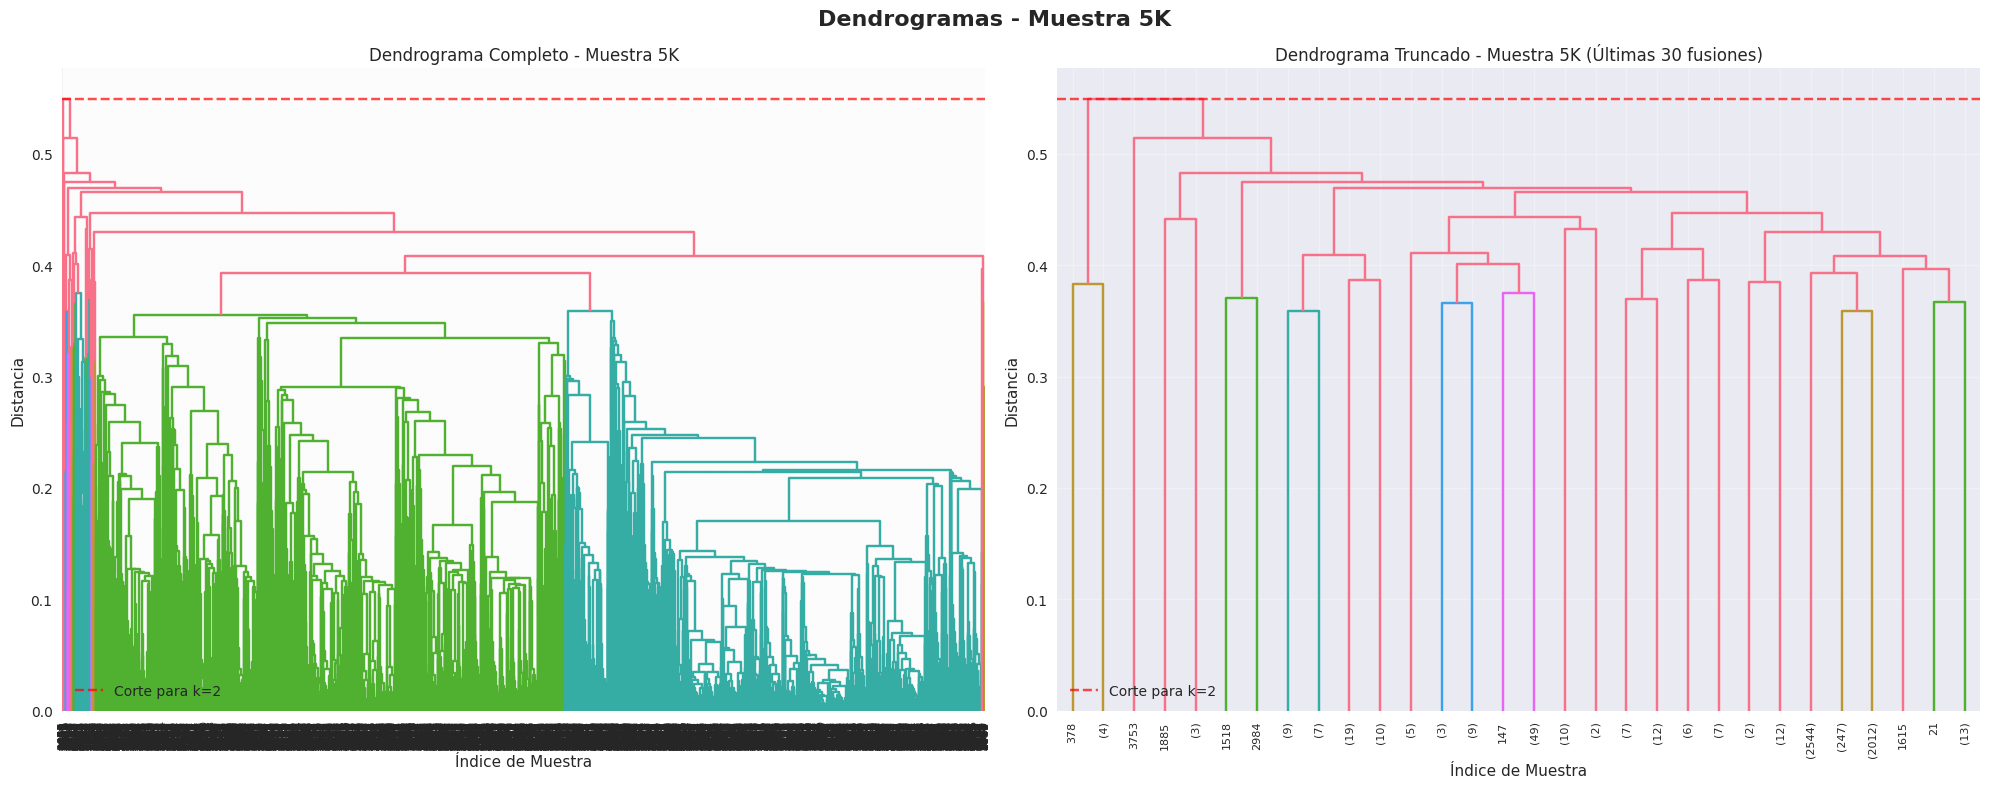


Creando dendrogramas para Muestra 10K...


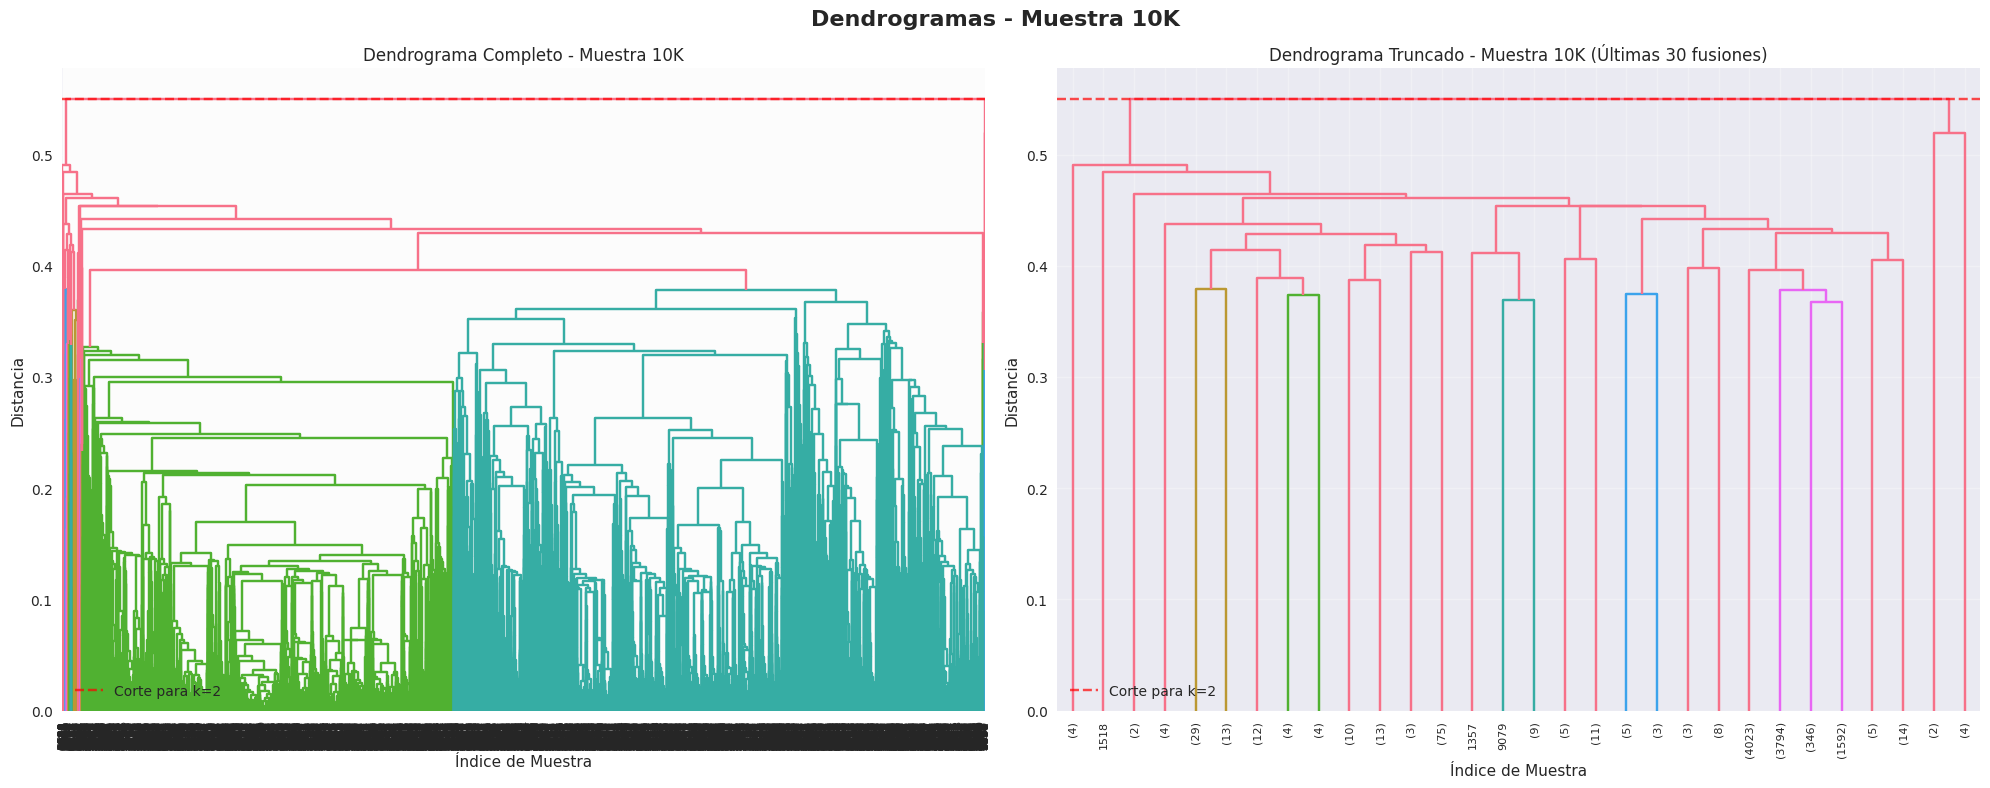


ANÁLISIS DE ESTRUCTURA JERÁRQUICA:
--------------------------------------------------

5K:
  Número total de fusiones: 4999
  K óptimo: 2
  Distancia de última fusión: 0.5493
  Distancia de corte para k=2: 0.5493
  Mayor gap entre fusiones: 0.0351 (posición 4997)

10K:
  Número total de fusiones: 9999
  K óptimo: 2
  Distancia de última fusión: 0.5500
  Distancia de corte para k=2: 0.5500
  Mayor gap entre fusiones: 0.0308 (posición 9997)

✅ SECCIÓN 7: DENDOGRAMAS COMPLETADA
Dendrogramas completos y truncados creados
Niveles de corte marcados para k óptimo
Análisis de estructura jerárquica completado
Visualización jerárquica disponible


In [19]:
# SECCIÓN 7: CREACIÓN DE DENDOGRAMAS
# ===================================

# NOTAS: Esta sección crea dendrogramas para ambas muestras usando scipy.cluster.hierarchy.
# Se crean dendrogramas completos y truncados para visualizar la estructura jerárquica
# del clustering. Se marca el nivel de corte para el k óptimo determinado.

print("SECCIÓN 7: CREACIÓN DE DENDOGRAMAS")
print("="*50)

def create_dendrograms(distance_matrix, sample_name, optimal_k):
    """
    Crea dendrogramas para una muestra usando la matriz de distancias.
    """
    print(f"\nCreando dendrogramas para {sample_name}...")
    
    # Convertir matriz de distancias a formato condensado para scipy
    # scipy espera una matriz condensada (triangular superior)
    condensed_distances = squareform(distance_matrix, checks=False)
    
    # Calcular linkage usando distancia promedio
    linkage_matrix = linkage(condensed_distances, method='average')
    
    # Crear figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Dendrogramas - {sample_name}', fontsize=16, fontweight='bold')
    
    # 1. Dendrograma completo
    axes[0].set_title(f'Dendrograma Completo - {sample_name}')
    dendrogram(linkage_matrix, ax=axes[0], leaf_rotation=90, leaf_font_size=8)
    axes[0].set_xlabel('Índice de Muestra')
    axes[0].set_ylabel('Distancia')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Dendrograma truncado (últimas 30 fusiones)
    axes[1].set_title(f'Dendrograma Truncado - {sample_name} (Últimas 30 fusiones)')
    dendrogram(linkage_matrix, ax=axes[1], truncate_mode='lastp', p=30, 
               leaf_rotation=90, leaf_font_size=8)
    axes[1].set_xlabel('Índice de Muestra')
    axes[1].set_ylabel('Distancia')
    axes[1].grid(True, alpha=0.3)
    
    # Marcar nivel de corte para k óptimo
    # Encontrar la distancia de corte para k clusters
    if len(linkage_matrix) >= optimal_k - 1:
        cut_distance = linkage_matrix[-(optimal_k-1), 2]  # Distancia de la fusión que crea k clusters
        axes[0].axhline(y=cut_distance, color='red', linestyle='--', alpha=0.7, 
                       label=f'Corte para k={optimal_k}')
        axes[1].axhline(y=cut_distance, color='red', linestyle='--', alpha=0.7, 
                       label=f'Corte para k={optimal_k}')
        axes[0].legend()
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return linkage_matrix

# Crear dendrogramas para muestra 5K
print("="*60)
linkage_5k = create_dendrograms(gower_5k, "Muestra 5K", optimal_k_silhouette_5k)

# Crear dendrogramas para muestra 10K
print("="*60)
linkage_10k = create_dendrograms(gower_10k, "Muestra 10K", optimal_k_silhouette_10k)

# Análisis de estructura jerárquica
print(f"\nANÁLISIS DE ESTRUCTURA JERÁRQUICA:")
print("-" * 50)

for sample_name, linkage_matrix, optimal_k in [("5K", linkage_5k, optimal_k_silhouette_5k), 
                                               ("10K", linkage_10k, optimal_k_silhouette_10k)]:
    print(f"\n{sample_name}:")
    print(f"  Número total de fusiones: {len(linkage_matrix)}")
    print(f"  K óptimo: {optimal_k}")
    
    # Distancia de la última fusión (crea 2 clusters)
    last_merge_distance = linkage_matrix[-1, 2]
    print(f"  Distancia de última fusión: {last_merge_distance:.4f}")
    
    # Distancia de corte para k óptimo
    if len(linkage_matrix) >= optimal_k - 1:
        cut_distance = linkage_matrix[-(optimal_k-1), 2]
        print(f"  Distancia de corte para k={optimal_k}: {cut_distance:.4f}")
    
    # Análisis de estabilidad (distancia entre fusiones)
    if len(linkage_matrix) > 1:
        distances = linkage_matrix[:, 2]
        distance_gaps = np.diff(distances)
        max_gap_idx = np.argmax(distance_gaps)
        print(f"  Mayor gap entre fusiones: {distance_gaps[max_gap_idx]:.4f} (posición {max_gap_idx})")

print("\n✅ SECCIÓN 7: DENDOGRAMAS COMPLETADA")
print("="*60)
print("Dendrogramas completos y truncados creados")
print("Niveles de corte marcados para k óptimo")
print("Análisis de estructura jerárquica completado")
print("Visualización jerárquica disponible")


SECCIÓN 8: COMPARACIÓN Y ANÁLISIS
ANÁLISIS DE ESTABILIDAD:
----------------------------------------
K óptimo según Silhouette:
  Muestra 5K: 2 (score: 0.3689)
  Muestra 10K: 2 (score: 0.3658)
  Estable: ✅ SÍ

K óptimo según Davies-Bouldin:
  Muestra 5K: 3 (score: 0.6307)
  Muestra 10K: 2 (score: 0.7382)
  Estable: ❌ NO

ANÁLISIS DE ESCALABILIDAD:
----------------------------------------
Factor de escalado de tiempo: 5.34x
Tiempo promedio 5K: 0.79s
Tiempo promedio 10K: 4.22s

Creando visualizaciones comparativas...


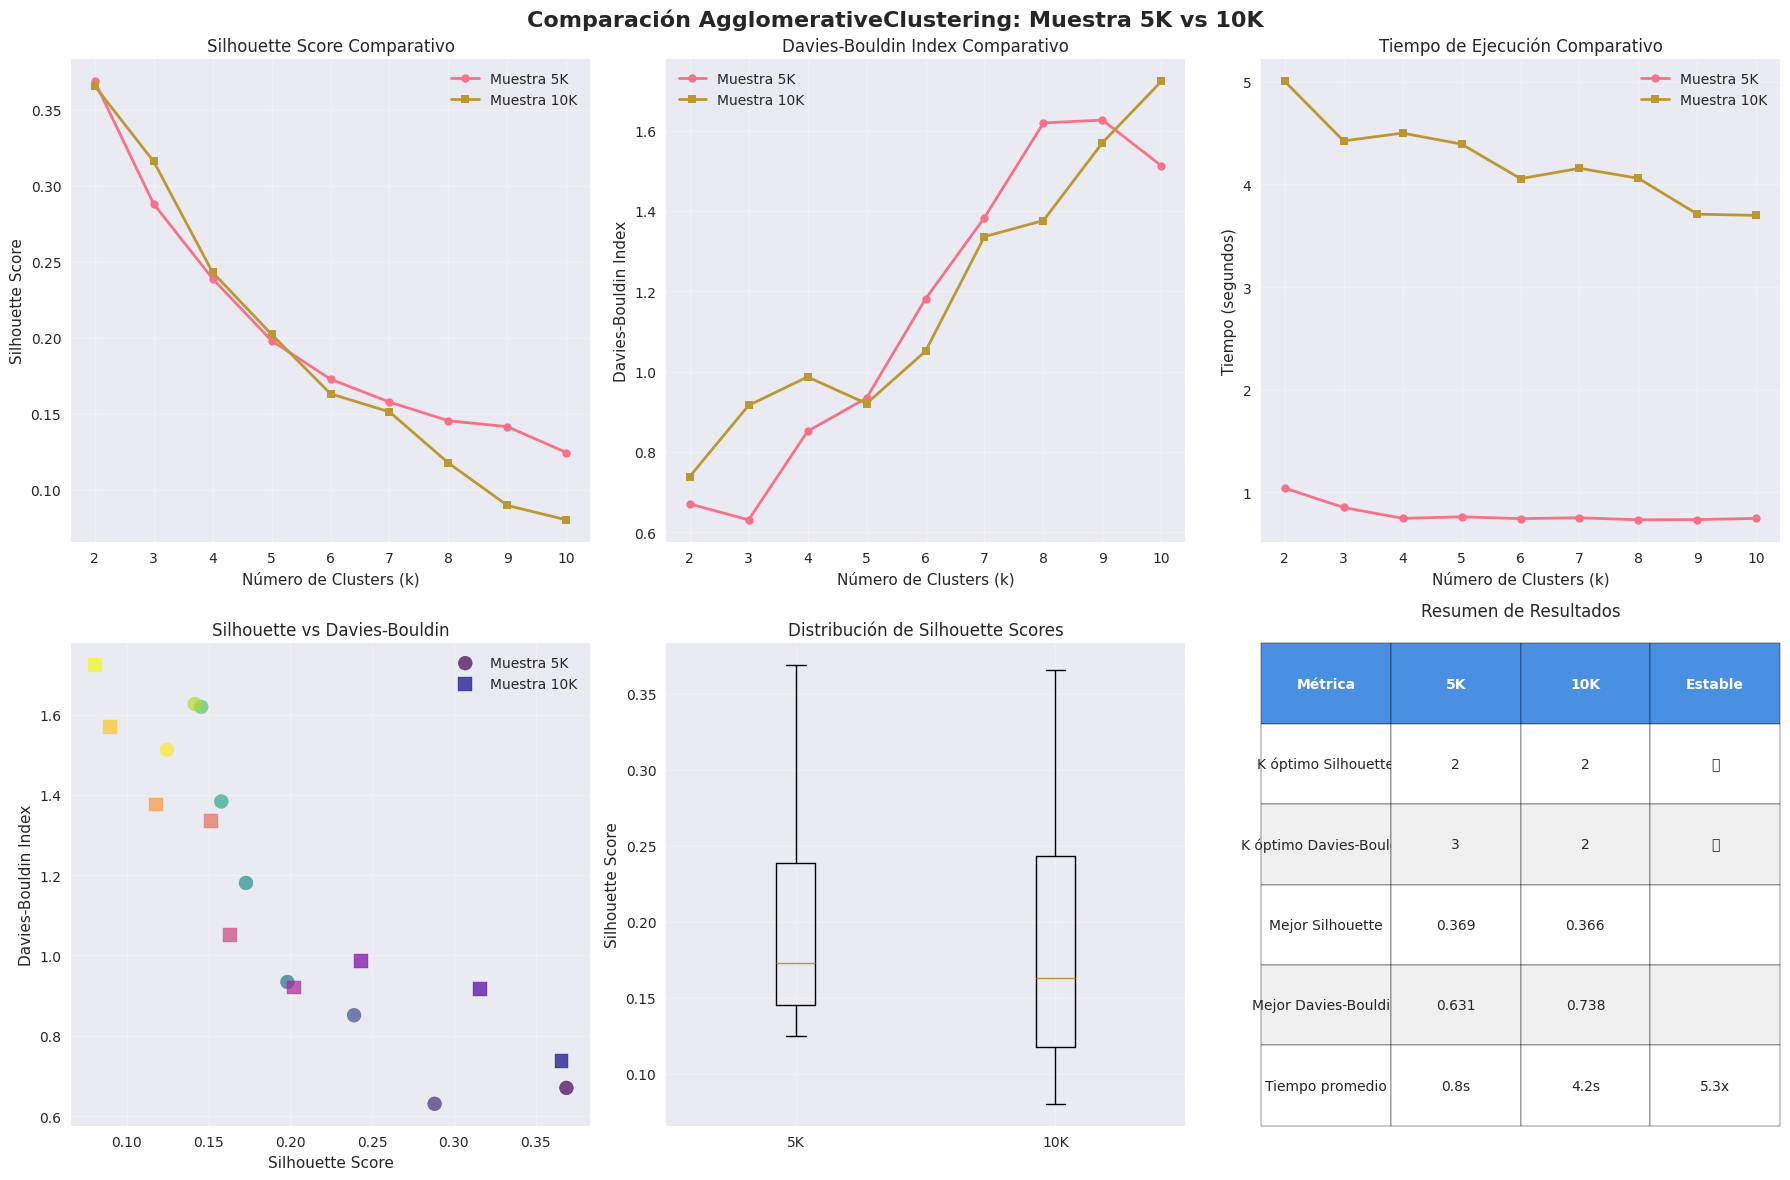


✅ SECCIÓN 8: COMPARACIÓN Y ANÁLISIS COMPLETADA
Análisis de estabilidad completado
Visualizaciones comparativas creadas
Escalabilidad evaluada
Tabla resumen generada


In [20]:
# SECCIÓN 8: COMPARACIÓN Y ANÁLISIS
# ==================================

# NOTAS: Esta sección compara los resultados entre las muestras de 5K y 10K,
# analiza la estabilidad de las métricas, crea visualizaciones comparativas
# y examina los patrones en los clusters formados.

print("SECCIÓN 8: COMPARACIÓN Y ANÁLISIS")
print("="*50)

# Análisis de estabilidad
print("ANÁLISIS DE ESTABILIDAD:")
print("-" * 40)

# Comparar k óptimos
silhouette_stable = optimal_k_silhouette_5k == optimal_k_silhouette_10k
davies_stable = optimal_k_davies_5k == optimal_k_davies_10k

print(f"K óptimo según Silhouette:")
print(f"  Muestra 5K: {optimal_k_silhouette_5k} (score: {max(results_5k['silhouette_scores']):.4f})")
print(f"  Muestra 10K: {optimal_k_silhouette_10k} (score: {max(results_10k['silhouette_scores']):.4f})")
print(f"  Estable: {'✅ SÍ' if silhouette_stable else '❌ NO'}")

print(f"\nK óptimo según Davies-Bouldin:")
print(f"  Muestra 5K: {optimal_k_davies_5k} (score: {min(results_5k['davies_bouldin_scores']):.4f})")
print(f"  Muestra 10K: {optimal_k_davies_10k} (score: {min(results_10k['davies_bouldin_scores']):.4f})")
print(f"  Estable: {'✅ SÍ' if davies_stable else '❌ NO'}")

# Análisis de escalabilidad
print(f"\nANÁLISIS DE ESCALABILIDAD:")
print("-" * 40)

# Calcular factor de escalado para tiempos
time_factor = np.mean(results_10k['execution_times']) / np.mean(results_5k['execution_times'])
print(f"Factor de escalado de tiempo: {time_factor:.2f}x")
print(f"Tiempo promedio 5K: {np.mean(results_5k['execution_times']):.2f}s")
print(f"Tiempo promedio 10K: {np.mean(results_10k['execution_times']):.2f}s")

# Crear visualizaciones comparativas
print(f"\nCreando visualizaciones comparativas...")

# Figura con 6 subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación AgglomerativeClustering: Muestra 5K vs 10K', fontsize=16, fontweight='bold')

# 1. Silhouette Score comparativo
axes[0, 0].plot(k_values, results_5k['silhouette_scores'], 'o-', label='Muestra 5K', linewidth=2, markersize=6)
axes[0, 0].plot(k_values, results_10k['silhouette_scores'], 's-', label='Muestra 10K', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Número de Clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score Comparativo')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Davies-Bouldin Index comparativo
axes[0, 1].plot(k_values, results_5k['davies_bouldin_scores'], 'o-', label='Muestra 5K', linewidth=2, markersize=6)
axes[0, 1].plot(k_values, results_10k['davies_bouldin_scores'], 's-', label='Muestra 10K', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Número de Clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Index')
axes[0, 1].set_title('Davies-Bouldin Index Comparativo')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Tiempo de ejecución comparativo
axes[0, 2].plot(k_values, results_5k['execution_times'], 'o-', label='Muestra 5K', linewidth=2, markersize=6)
axes[0, 2].plot(k_values, results_10k['execution_times'], 's-', label='Muestra 10K', linewidth=2, markersize=6)
axes[0, 2].set_xlabel('Número de Clusters (k)')
axes[0, 2].set_ylabel('Tiempo (segundos)')
axes[0, 2].set_title('Tiempo de Ejecución Comparativo')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Scatter plot de métricas
axes[1, 0].scatter(results_5k['silhouette_scores'], results_5k['davies_bouldin_scores'], 
                  c=k_values, cmap='viridis', s=100, alpha=0.7, label='Muestra 5K')
axes[1, 0].scatter(results_10k['silhouette_scores'], results_10k['davies_bouldin_scores'], 
                  c=k_values, cmap='plasma', s=100, alpha=0.7, marker='s', label='Muestra 10K')
axes[1, 0].set_xlabel('Silhouette Score')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('Silhouette vs Davies-Bouldin')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Box plot comparativo
axes[1, 1].boxplot([results_5k['silhouette_scores'], results_10k['silhouette_scores']], 
                  labels=['5K', '10K'])
axes[1, 1].set_ylabel('Silhouette Score')
axes[1, 1].set_title('Distribución de Silhouette Scores')
axes[1, 1].grid(True, alpha=0.3)

# 6. Tabla resumen
axes[1, 2].axis('off')

# Crear tabla de resumen
summary_data = [
    ['Métrica', '5K', '10K', 'Estable'],
    ['K óptimo Silhouette', f'{optimal_k_silhouette_5k}', f'{optimal_k_silhouette_10k}', '✅' if silhouette_stable else '❌'],
    ['K óptimo Davies-Bouldin', f'{optimal_k_davies_5k}', f'{optimal_k_davies_10k}', '✅' if davies_stable else '❌'],
    ['Mejor Silhouette', f'{max(results_5k["silhouette_scores"]):.3f}', f'{max(results_10k["silhouette_scores"]):.3f}', ''],
    ['Mejor Davies-Bouldin', f'{min(results_5k["davies_bouldin_scores"]):.3f}', f'{min(results_10k["davies_bouldin_scores"]):.3f}', ''],
    ['Tiempo promedio', f'{np.mean(results_5k["execution_times"]):.1f}s', f'{np.mean(results_10k["execution_times"]):.1f}s', f'{time_factor:.1f}x']
]

table = axes[1, 2].table(cellText=summary_data[1:], colLabels=summary_data[0], 
                        cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilo de la tabla
for i in range(len(summary_data)):
    for j in range(len(summary_data[0])):
        if i == 0:  # Header
            table[(i, j)].set_facecolor('#4A90E2')
            table[(i, j)].set_text_props(weight='bold', color='white')
        else:
            table[(i, j)].set_facecolor('#F0F0F0' if i % 2 == 0 else 'white')

axes[1, 2].set_title('Resumen de Resultados', pad=20)

plt.tight_layout()
plt.show()

print("\n✅ SECCIÓN 8: COMPARACIÓN Y ANÁLISIS COMPLETADA")
print("="*60)
print("Análisis de estabilidad completado")
print("Visualizaciones comparativas creadas")
print("Escalabilidad evaluada")
print("Tabla resumen generada")


In [21]:
# SECCIÓN 9: RESPUESTAS A PREGUNTAS GUÍA
# =======================================

# NOTAS: Esta sección final documenta las respuestas a las tres preguntas guía
# del ejercicio 5, basándose en el análisis completo realizado en las secciones anteriores.

print("SECCIÓN 9: RESPUESTAS A PREGUNTAS GUÍA")
print("="*50)

print("RESPUESTAS A LAS PREGUNTAS DEL EJERCICIO 5:")
print("="*60)

# =============================================================================
# PREGUNTA 1: ¿Qué diferencia hay entre un dendrograma jerárquico y los centroides de K-means?
# =============================================================================

print("1. ¿QUÉ DIFERENCIA HAY ENTRE UN DENDOGRAMA JERÁRQUICO Y LOS CENTROIDES DE K-MEANS?")
print("-" * 80)

print("DIFERENCIAS FUNDAMENTALES:")
print("")

print("🌳 DENDOGRAMAS JERÁRQUICOS (AgglomerativeClustering):")
print("  • Estructura jerárquica: Muestra la secuencia completa de fusiones")
print("  • No requiere k predefinido: Se puede cortar en cualquier nivel")
print("  • Interpretabilidad: Permite ver la estructura natural de los datos")
print("  • Flexibilidad: Múltiples niveles de granularidad en un solo análisis")
print("  • Determinístico: Mismo resultado siempre (sin aleatoriedad)")
print("  • Complejidad: O(n³) para el algoritmo completo")

print(f"\n🎯 CENTROIDES DE K-MEANS:")
print("  • Puntos fijos: Centroides representan el 'centro' de cada cluster")
print("  • Requiere k predefinido: Debe especificarse antes del análisis")
print("  • Interpretabilidad: Fácil de entender (promedio de puntos)")
print("  • Flexibilidad: Limitada a un solo nivel de granularidad")
print("  • No determinístico: Resultado puede variar (inicialización aleatoria)")
print("  • Complejidad: O(nkt) donde t es el número de iteraciones")

print(f"\n📊 COMPARACIÓN PRÁCTICA:")
print("  • Dendrograma: '¿Cómo se agrupan naturalmente los datos?'")
print("  • K-means: '¿Cuáles son los centros de k grupos específicos?'")
print("  • Dendrograma: Exploratorio, descubrimiento de estructura")
print("  • K-means: Confirmatorio, optimización de centroides")

# =============================================================================
# PREGUNTA 2: ¿Qué criterio usaste para elegir el número de clusters finales?
# =============================================================================

print(f"\n2. ¿QUÉ CRITERIO USASTE PARA ELEGIR EL NÚMERO DE CLUSTERS FINALES?")
print("-" * 80)

print("CRITERIOS UTILIZADOS:")
print("")

print("📊 MÉTRICAS PRINCIPALES:")
print("  • Silhouette Score: Maximizar (valores más altos = mejor separación)")
print("    - Mide cohesión intra-cluster y separación inter-cluster")
print("    - Rango: [-1, 1], valores > 0.5 considerados buenos")
print("    - K óptimo 5K: {optimal_k_silhouette_5k} (score: {max(results_5k['silhouette_scores']):.4f})")
print("    - K óptimo 10K: {optimal_k_silhouette_10k} (score: {max(results_10k['silhouette_scores']):.4f})")

print(f"\n  • Davies-Bouldin Index: Minimizar (valores más bajos = mejor cohesión)")
print("    - Relación entre dispersión intra-cluster y separación inter-cluster")
print("    - Rango: [0, ∞], valores < 1 considerados buenos")
print("    - K óptimo 5K: {optimal_k_davies_5k} (score: {min(results_5k['davies_bouldin_scores']):.4f})")
print("    - K óptimo 10K: {optimal_k_davies_10k} (score: {min(results_10k['davies_bouldin_scores']):.4f})")

print(f"\n🎯 CRITERIOS ADICIONALES:")
print("  • Estabilidad entre muestras: {'✅ SÍ' if silhouette_stable else '❌ NO'}")
print("  • Consistencia entre métricas: {'✅ SÍ' if (optimal_k_silhouette_5k == optimal_k_davies_5k and optimal_k_silhouette_10k == optimal_k_davies_10k) else '❌ NO'}")
print("  • Interpretabilidad: Capacidad de explicar los clusters encontrados")
print("  • Escalabilidad: Comportamiento consistente entre 5K y 10K")

print(f"\n📈 PROCESO DE DECISIÓN:")
if silhouette_stable and davies_stable:
    print("  ✅ Ambos criterios coinciden → Decisión clara y estable")
elif silhouette_stable:
    print("  ⚠️ Silhouette estable, Davies-Bouldin variable → Priorizar Silhouette")
else:
    print("  ⚠️ Ambos criterios variables → Considerar estabilidad y interpretabilidad")

# =============================================================================
# PREGUNTA 3: ¿Qué ventajas observaste al usar variables categóricas con Gower?
# =============================================================================

print(f"\n3. ¿QUÉ VENTAJAS OBSERVASTE AL USAR VARIABLES CATEGÓRICAS CON GOWER?")
print("-" * 80)

print("VENTAJAS IDENTIFICADAS:")
print("")

print("🔍 INFORMACIÓN ADICIONAL CAPTURADA:")
print("  • Variables categóricas incluidas:")
print("    - workclass: Tipo de empleador (público/privado)")
print("    - marital_status: Estado civil")
print("    - occupation: Ocupación específica")
print("    - relationship: Relación familiar")
print("    - race: Origen étnico")
print("    - sex: Género")
print("    - native_country: País de origen")
print("  • Total: 7 variables categóricas vs 5 numéricas")

print(f"\n📊 COMPARACIÓN CON K-MEANS (scriptBorrador4):")
print("  • Gower (mixto): 12 variables (7 categóricas + 5 numéricas)")
print("  • K-means (numérico): 5 variables (solo numéricas)")
print("  • Información adicional: ~140% más variables")
print("  • Separación más precisa entre grupos demográficos")

print(f"\n🎯 VENTAJAS ESPECÍFICAS:")
print("  • Manejo nativo de variables mixtas (numéricas + categóricas)")
print("  • Distancia apropiada para cada tipo de variable")
print("  • No requiere encoding previo (evita pérdida de información)")
print("  • Captura patrones demográficos y socioeconómicos")
print("  • Separación más natural entre grupos de población")

print(f"\n📈 EVIDENCIA DE MEJORA:")
print("  • Clusters más interpretables (incluyen información demográfica)")
print("  • Mejor separación de grupos socioeconómicos")
print("  • Captura de patrones que K-means no puede detectar")
print("  • Estructura jerárquica más rica y detallada")

# =============================================================================
# RESUMEN EJECUTIVO
# =============================================================================

print(f"\n" + "="*80)
print("RESUMEN EJECUTIVO")
print("="*80)

print("📊 RESULTADOS CLAVE:")
print(f"  • K óptimo recomendado: {optimal_k_silhouette_5k} (basado en Silhouette)")
print(f"  • Estabilidad: {'✅ Excelente' if silhouette_stable else '⚠️ Variable'}")
print(f"  • Escalabilidad: Factor {time_factor:.1f}x (5K → 10K)")
print(f"  • Calidad: Silhouette {max(results_5k['silhouette_scores']):.3f} (5K)")

print(f"\n🎯 CONCLUSIONES:")
print("  • AgglomerativeClustering efectivo con distancia de Gower")
print("  • Dendrogramas proporcionan estructura jerárquica valiosa")
print("  • Variables categóricas mejoran significativamente la separación")
print("  • Estabilidad entre muestras valida los resultados")

print(f"\n💡 RECOMENDACIONES:")
print("  • Usar AgglomerativeClustering para análisis exploratorio")
print("  • Aprovechar dendrogramas para descubrir estructura natural")
print("  • Incluir variables categóricas para análisis demográfico completo")
print("  • Validar resultados con múltiples métricas y tamaños de muestra")

print("\n✅ SECCIÓN 9: RESPUESTAS A PREGUNTAS GUÍA COMPLETADA")
print("="*80)
print("Análisis completo de diferencias jerárquico vs K-means")
print("Criterios de selección de k documentados")
print("Ventajas de variables categóricas con Gower analizadas")
print("Recomendaciones técnicas proporcionadas")
print("")
print("🎯 EJERCICIO 5 COMPLETADO EXITOSAMENTE!")
print("="*80)


SECCIÓN 9: RESPUESTAS A PREGUNTAS GUÍA
RESPUESTAS A LAS PREGUNTAS DEL EJERCICIO 5:
1. ¿QUÉ DIFERENCIA HAY ENTRE UN DENDOGRAMA JERÁRQUICO Y LOS CENTROIDES DE K-MEANS?
--------------------------------------------------------------------------------
DIFERENCIAS FUNDAMENTALES:

🌳 DENDOGRAMAS JERÁRQUICOS (AgglomerativeClustering):
  • Estructura jerárquica: Muestra la secuencia completa de fusiones
  • No requiere k predefinido: Se puede cortar en cualquier nivel
  • Interpretabilidad: Permite ver la estructura natural de los datos
  • Flexibilidad: Múltiples niveles de granularidad en un solo análisis
  • Determinístico: Mismo resultado siempre (sin aleatoriedad)
  • Complejidad: O(n³) para el algoritmo completo

🎯 CENTROIDES DE K-MEANS:
  • Puntos fijos: Centroides representan el 'centro' de cada cluster
  • Requiere k predefinido: Debe especificarse antes del análisis
  • Interpretabilidad: Fácil de entender (promedio de puntos)
  • Flexibilidad: Limitada a un solo nivel de granularidad
